# Problem Set #6
## MACS 20100, Dr. Evans
Feb. 25, 20  
Mengchen Shi

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [2]:
df = pd.read_csv('biden.csv')

In [3]:
df.head()

,biden,female,age,educ,dem,rep
0,90,0,19,12,1,0
1,70,1,51,14,1,0
2,60,0,27,14,0,0
3,50,1,43,14,1,0
4,60,1,38,14,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1807 entries, 0 to 1806
Data columns (total 6 columns):
biden     1807 non-null int64
female    1807 non-null int64
age       1807 non-null int64
educ      1807 non-null int64
dem       1807 non-null int64
rep       1807 non-null int64
dtypes: int64(6)
memory usage: 84.8 KB


## (a)
Split the data into a training set (70%) and a test set (30%). Be sure to set your seed prior to this part of your code to guarantee reproducibility of results. Use recursive binary splitting to fit a decision tree to the train- ing data, with biden as the response variable and the other variables as predictors. Plot the tree and interpret the results. What is the test MSE?

In [5]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
y = df['biden'].values
X = df[['female', 'age', 'educ', 'dem', 'rep']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [7]:
biden_tree1 = DecisionTreeRegressor(max_depth=2, min_samples_leaf=5)
biden_tree1.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [8]:
y_train.mean()

62.164556962025316

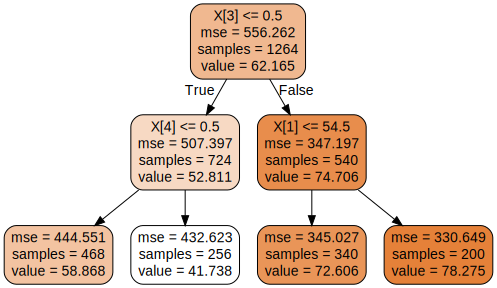

In [9]:
from sklearn.tree import export_graphviz
import graphviz

hit_tree_viz1 = export_graphviz(
    biden_tree1,
    out_file=None,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(hit_tree_viz1)
graph.render('hit_tree_viz1')
graph

x[0]='female', x[1]='age', x[2]='educ', x[3]='dem', x[4]='rep'

There are 1264 individuals in the train set, and their average feeling for Biden is 62.

The first split occurs at Democrat or non-Democrat. It appears that Democrats have warmer feelings(value=52) to Biden than non-Democracts(value=74), which is reasonable.

If a person is a non-Democrat, the second split is if this person is a Republican or a non-Republican. It appears that non-Republicans have warmer feelings(value=58) for Biden than Republicans(value=41.738). 

If a person is a Democrat, the second split is age. People older than 54.5 have warmer feelings(value=78) for Biden than people younger than 54.5(value=72). 

In [25]:
y_pred1 = biden_tree1.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred1)
print('MSE =', MSE1)

MSE = 400.06539818418173


## (b)
Leave the control options for tree() at their default values. Now fit another tree to the training data with the following control options: tree(control = tree.control(nobs = # number of rows in the training set, mindev = 0)) Use cross-validation to determine the optimal level of tree complexity, plot the optimal tree, and interpret the results. Does pruning the tree improve the test MSE?

In [12]:
MSE = [0]*100
for i in range(1, 101):
    biden_tree2 = DecisionTreeRegressor(max_depth=i, min_samples_leaf=5)
    biden_tree2.fit(X_train, y_train)
    y_pred2 = biden_tree2.predict(X_test)
    MSE[i-1] = mean_squared_error(y_test, y_pred2)

In [13]:
print('The optimal MSE: ', min(MSE))
print('the optimal level of tree complexity: ', MSE.index(min(MSE)) + 1)

The optimal MSE:  396.1937146321307
the optimal level of tree complexity:  3


In [14]:
biden_tree2 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
biden_tree2.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

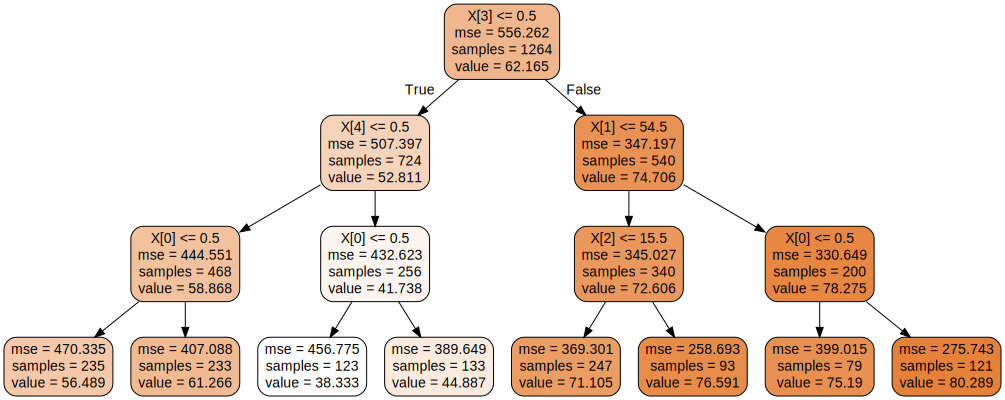

In [15]:
hit_tree_viz2 = export_graphviz(
    biden_tree2,
    out_file=None,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(hit_tree_viz2)
graph.render('hit_tree_viz1')
graph

x[0]='female', x[1]='age',  x[2]='educ', x[3]='dem', x[4]='rep'

The first split occurs at Democrat or non-Democrat. It appears that Democrats have warmer feelings(value=52) to Biden than non-Democracts(value=74), which is reasonable. 

If a person is a non-Democrat, the second split is if she is a Republican or a non-Republican. It appears that non-Republicans have warmer feelings(value=58) for Biden than Republicans(value=41.738). Then the split occurs at whether a person is female. In general, for both non-Republican and Republicans, females have warmer feelings for Biden than males.

If a person is a Democrat, the second split is age. People older than 54.5 have warmer feelings(value=78) for Biden than people younger than 54.5(value=72). For elder people, the next split is years of education, where people with higher years of education(>15.5) like Biden(76) more than those with lower years of education(< 15.5 ). For younger people, the next split is gender. Similarly, females tend to like Biden(value=80) more than males(75).

#### Pruning the tree does improve the test MSE since it reduces MSE.

## (c)
Use the bagging approach to estimate a tree to create a model for predict- ing biden. What test MSE do you obtain? Obtain variable importance measures and interpret the results.

In [16]:
from sklearn.ensemble import BaggingRegressor

In [17]:
biden_tree3 = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100,
                             max_samples=100, bootstrap=True, oob_score=True, random_state=15)

biden_tree3.fit(X, y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=100, n_jobs=1, oob_score=True,
         random_state=15, verbose=0, warm_start=False)

In [18]:
biden_tree3.score(X, y)
y_pred3 = biden_tree3.oob_prediction_
MSE3 = mean_squared_error(y, y_pred3)
print('MSE=', MSE3)

MSE= 406.0005583949261


In [21]:
importances = np.mean([tree.feature_importances_ for tree in biden_tree3.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

features = ['female', 'age', 'dem', 'rep', 'educ']
for i in range(X.shape[1]):
    print(str(i+1), ". ", features[i], ": ",str(importances[indices[i]]))
    

Feature ranking:
1 .  female :  0.4429127039606069
2 .  age :  0.20057625971613363
3 .  dem :  0.19032354439169072
4 .  rep :  0.10602822551257896
5 .  educ :  0.06015926641898977


##### Interpretation: 
$female$ appears to be the most important variable in the model to explain $biden$. After that, $age$,  $dem$ and $rep$ are the next important variables. After that, $educ$ seems to be of least importance.

In [ ]:
#importances

In [ ]:
#np.argsort(importances)

In [ ]:
#indices1

## (d)
Use the random forest approach to estimate a tree to create a model for predictingbiden. Do this for m=1,m=2,and m=3(the number of variables). What test MSE do you obtain in each case? Obtain variable importance measures and interpret the results. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
def get_importances(biden_tree, features):
    importances = np.mean([tree.feature_importances_ for tree in biden_tree.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")
    
    for i in range(len(features)):
        print(str(i+1), ". ", features[i], ": ",str(importances[indices[i]]))

def build_tree(m, X, y, features):
    biden_tree = RandomForestRegressor(n_estimators=53, max_features=m, bootstrap=True,
                                  oob_score=True, random_state=15)
    biden_tree.fit(X, y)
    biden_tree.score(X, y)
    
    y_pred = biden_tree.oob_prediction_
    MSE = mean_squared_error(y, y_pred)
    print('m =', m, ', MSE = ', MSE)
    get_importances(biden_tree, features)

In [29]:
for m in range(1, 4):
    build_tree(m, X, y, features)
    print()

m = 1 , MSE =  532.8750579722736
Feature ranking:
1 .  female :  0.5121750986284854
2 .  age :  0.19243207162937045
3 .  dem :  0.1501805471537288
4 .  rep :  0.12387921818323254
5 .  educ :  0.02133306440518276

m = 2 , MSE =  538.192542935064
Feature ranking:
1 .  female :  0.5075843112401004
2 .  age :  0.19194351404282559
3 .  dem :  0.1514236956156639
4 .  rep :  0.1279439072674188
5 .  educ :  0.02110457183399131

m = 3 , MSE =  535.7619627008756
Feature ranking:
1 .  female :  0.4846520363670528
2 .  age :  0.19916532223909172
3 .  dem :  0.16508946236227023
4 .  rep :  0.12372237934495427
5 .  educ :  0.027370799686630812



For each m, $female$ is always the most important variable for the model, followed by $age$, $dem$, $rep$ and $educ$ in order. In addition, the importance measures for the variables do not vary much for different m. There is no obvious relationship betwen m and MSE. In this case, MSE is smallest with m=1.